In [116]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

columns = ['tavg', 'rh_avg', 'rr', 'ff_avg']
predict_col = 'rr'

device(type='cpu')

In [ ]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()


def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior],
             targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end],
             targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior],
                color='k', linestyle="--", linewidth=1)
    plt.legend()

In [117]:
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y')
df = pd.read_csv('../Assets/Data/1985-2021.csv', date_parser=dateparse, parse_dates=['tanggal'], index_col=['tanggal'], usecols=['tanggal', 'tavg', 'rh_avg', 'rr', 'ff_avg']).replace(to_replace=[8888, 9999, 2555], value=np.nan)

In [118]:
df.interpolate(inplace=True)

In [119]:
scaller = MinMaxScaler(feature_range=(0, 1))
df[columns] = scaller.fit_transform(df[columns])

In [120]:
config = set_config({
    "input_size": columns.__len__(),
    "seq_len": 7,
    "batch_size": 32,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "learning_rate": 0.01,
})

In [121]:
ts_train, ts_test = train_test_split(df, test_size=0.1, shuffle=False)

train_set = TimeSeriesDataset(ts_train, predict_col, config.seq_len)
trainloader = DataLoader(train_set, batch_size=config.batch_size)

test_set = TimeSeriesDataset(ts_test, predict_col, config.seq_len)
testloader = DataLoader(test_set, batch_size=config.batch_size)

(N, S, F): (1674, 7, 4)
Note: last 6 data excluded

(N, S, F): (186, 7, 4)
Note: last 0 data excluded



In [122]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout, bidirectional):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional:
            hidden_size = 2*hidden_size
            
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [123]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [124]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout, config.bidirectional).to(device)
criterion = RMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
callback = Callback(model, config, outdir=f'model/jkse/')

In [125]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    return cost / len(dataset)

Test: 100%|██████████| 6/6 [00:00<00:00, 31.12it/s]



Epoch     1
Train_cost  = 0.0866 | Test_cost  = 0.0723 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 43.50it/s]



Epoch     2
Train_cost  = 0.0759 | Test_cost  = 0.0680 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 41.12it/s]



Epoch     3
Train_cost  = 0.0748 | Test_cost  = 0.0676 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 43.50it/s]



Epoch     4
Train_cost  = 0.0744 | Test_cost  = 0.0665 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 40.02it/s]



Epoch     5
Train_cost  = 0.0746 | Test_cost  = 0.0662 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 38.48it/s]



Epoch     6
Train_cost  = 0.0741 | Test_cost  = 0.0657 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 42.58it/s]



Epoch     7
Train_cost  = 0.0744 | Test_cost  = 0.0658 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0657


Test: 100%|██████████| 6/6 [00:00<00:00, 32.98it/s]



Epoch     8
Train_cost  = 0.0741 | Test_cost  = 0.0654 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 32.11it/s]



Epoch     9
Train_cost  = 0.0743 | Test_cost  = 0.0652 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 37.93it/s]



Epoch    10
Train_cost  = 0.0740 | Test_cost  = 0.0651 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 37.76it/s]



Epoch    11
Train_cost  = 0.0742 | Test_cost  = 0.0650 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 39.76it/s]



Epoch    12
Train_cost  = 0.0739 | Test_cost  = 0.0645 | 


Test: 100%|██████████| 6/6 [00:00<00:00, 47.27it/s]



Epoch    13
Train_cost  = 0.0740 | Test_cost  = 0.0646 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0645


Test: 100%|██████████| 6/6 [00:00<00:00, 44.47it/s]



Epoch    14
Train_cost  = 0.0736 | Test_cost  = 0.0647 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0645


Test: 100%|██████████| 6/6 [00:00<00:00, 46.13it/s]



Epoch    15
Train_cost  = 0.0739 | Test_cost  = 0.0646 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0645


Test: 100%|██████████| 6/6 [00:00<00:00, 30.19it/s]



Epoch    16
Train_cost  = 0.0733 | Test_cost  = 0.0647 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0645


Test: 100%|██████████| 6/6 [00:00<00:00, 41.12it/s]



Epoch    17
Train_cost  = 0.0737 | Test_cost  = 0.0647 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0645
==> Execute Early Stopping at epoch: 17 | Best test_cost: 0.0645
==> Best model is saved at model/jkse/


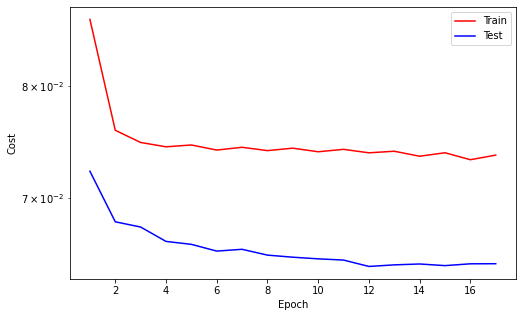

In [126]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [127]:
ts_train

,tavg,rh_avg,rr,ff_avg
tanggal,,,,
1985-01-01,0.640777,0.562500,0.000000,0.00000
1985-01-02,0.417476,0.796875,0.089506,0.00000
1985-01-03,0.514563,0.875000,0.000000,0.00000
1985-01-04,0.368932,0.890625,0.160494,0.00000
1985-01-05,0.388350,0.843750,0.009259,0.00000
...,...,...,...,...
2018-06-03,0.631068,0.750000,0.043210,0.00625
2018-06-04,0.679612,0.750000,0.037037,0.00625
2018-06-05,0.679612,0.796875,0.030864,0.00000


In [ ]:
train = scaller.inverse_transform(ts_train)

In [128]:
# ts_train = pd.DataFrame(scaller.inverse_transform(ts_train), columns=columns).set_index(pd.Series(datelist_future))
# ts_test = pd.DataFrame(scaller.inverse_transform(ts_test), columns=columns).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

In [129]:
train_forecast_set = TimeSeriesDataset(ts_train, predict_col, 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, predict_col, 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (11724, 1, 4)
Note: last 0 data excluded

(N, S, F): (1302, 1, 4)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

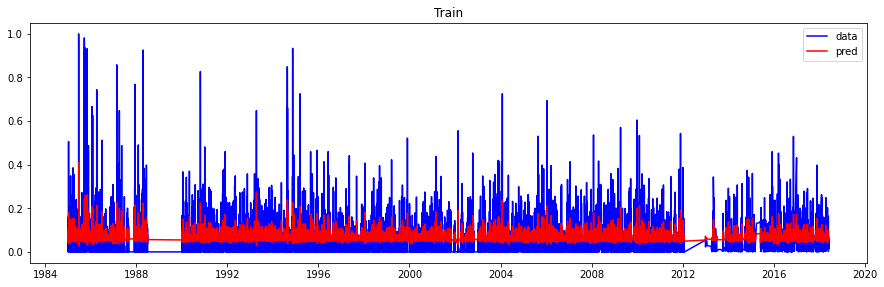

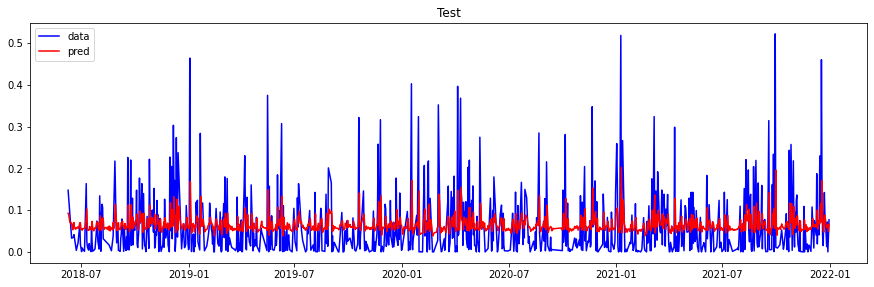

In [130]:
plt.figure(figsize=(15, 15))
plt.subplot(311)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.figure(figsize=(15, 15))
plt.subplot(312)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

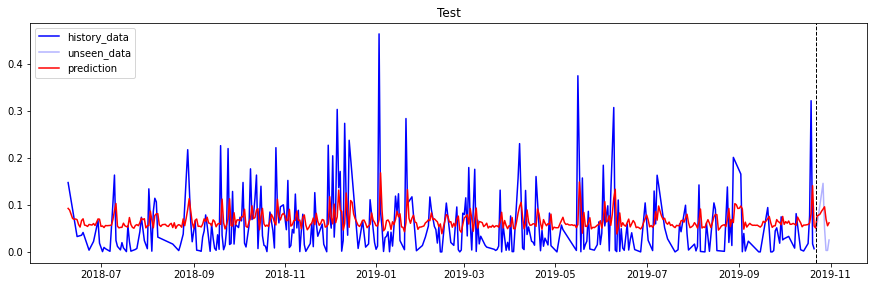

In [131]:
plt.figure(figsize=(15, 15))
plt.subplot(313)
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=500, n_forecast=10)
plt.title("Test")